In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tqdm import tqdm

class ResiduaBlock(keras.Model):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(ResiduaBlock, self).__init__()

        self.residual_block = keras.Sequential([
            keras.layers.Conv2D(out_channels, kernel_size, stride, padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.LeakyReLU(),
            keras.layers.Conv2D(out_channels, kernel_size, stride, padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.LeakyReLU()
        ], name='ResidualBlock')

    def call(self, x):
        return x + self.residual_block(x)

    def build_graph(self):
        x = keras.layers.Input(shape=(256, 256, 3))
        return keras.models.Model(inputs=[x], outputs=self.call(x))


class ResNetEncoder(keras.Model):
    def __init__(self,
                 n_ResidualBlock=8,
                 n_levels=4,
                 input_ch=3,
                 z_dim=10,
                 bUseMultiResSkips=True):
        super(ResNetEncoder, self).__init__()

        self.max_filters = 2 ** (n_levels + 3)
        self.n_levels = n_levels
        self.bUseMultiResSkips = bUseMultiResSkips

        self.conv_list = []
        self.res_blk_list = []
        self.multi_res_skip_list = []

        self.input_conv = keras.Sequential([
            keras.layers.Conv2D(8, 3, 1, padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.LeakyReLU(0.2)
        ], name='en_input_conv')

        for i in range(n_levels):
            n_filters_1 = 2 ** (i + 3)
            n_filters_2 = 2 ** (i + 4)
            ks = 2 ** (n_levels - i)

            self.res_blk_list.append(
                keras.Sequential([ResiduaBlock(n_filters_1, n_filters_1) for _ in range(n_ResidualBlock)]
                                 , name='res_block_' + str(i))
            )

            self.conv_list.append(
                keras.Sequential([
                    keras.layers.Conv2D(n_filters_2, 2, strides=2, padding='valid'),
                    keras.layers.BatchNormalization(),
                    keras.layers.LeakyReLU(0.2)
                ], name='conv_block_' + str(i))
            )

            if bUseMultiResSkips:
                self.multi_res_skip_list.append(
                    keras.Sequential([
                        keras.layers.Conv2D(self.max_filters,
                                            ks, ks, padding='valid'),
                        keras.layers.BatchNormalization(),
                        keras.layers.LeakyReLU(0.2)
                    ], name='multi_skip_block_' + str(i))
                )
        self.output_conv = keras.layers.Conv2D(z_dim, 3, 1, padding='same')

    def call(self, x):
        x = self.input_conv(x)

        skips = []

        for i in range(self.n_levels):
            x = self.res_blk_list[i](x)
            if self.bUseMultiResSkips:
                skips.append(self.multi_res_skip_list[i](x))
            x = self.conv_list[i](x)

        if self.bUseMultiResSkips:
            x = sum([x] + skips)

        x = self.output_conv(x)

        return x

    def build_graph(self):
        x = keras.layers.Input(shape=(256, 256, 3))
        return keras.models.Model(inputs=[x], outputs=self.call(x))


input_size= 256
batch_size=32

encoder = ResNetEncoder(n_ResidualBlock=8,n_levels=4,input_ch=3,z_dim=128,bUseMultiResSkips=True)
input = keras.layers.Input(shape=(256,256,3))

encoder_output = encoder(input)
flatten = keras.layers.Flatten()(encoder_output)

branch1_class = keras.layers.Dense(133,activation='softmax',name='branch1_class')(flatten)

branch2_landmark = keras.layers.Dense(16,name='branch2_landmark')(flatten)

out= keras.layers.concatenate([branch1_class,branch2_landmark])       # concatnate?

model = keras.models.Model(input, out)
model.compile(loss={'branch1_class':'sparse_categorical_crossentropy',
                    'branch2_landmark':'Mean_Squared_error'},
              optimizer='adam',
              metrics={'branch1_class':'accuracy'})
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 res_net_encoder (ResNetEncoder  (None, 16, 16, 128)  1479600    ['input_1[0][0]']                
 )                                                                                                
                                                                                                  
 flatten (Flatten)              (None, 32768)        0           ['res_net_encoder[0][0]']        
                                                                                              

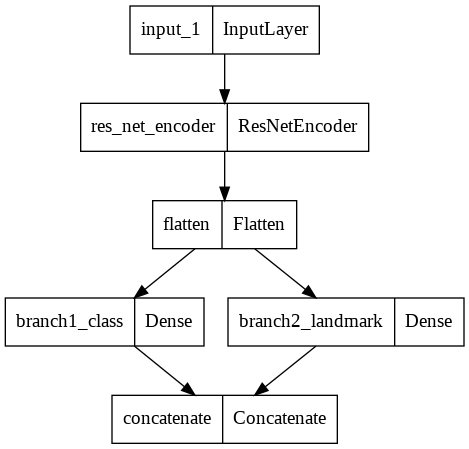

In [2]:
tf.keras.utils.plot_model(model)

In [ ]:
train_ds

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, None)), types: (tf.float32, tf.float32)>

In [14]:
def loss_mae(y_true, y_pred):
  x_left_top_gt, y_left_top_gt, x_right_top_gt, y_right_top_gt, x_center_top_gt, y_center_top_gt, x_left_ear_gt, y_left_ear_gt,
  x_right_ear_gt,y_right_ear_gt, x_left_eye_gt,y_left_eye_gt, x_right_eye_gt, y_right_eye_gt, x_nose_gt,y_nose_gt = tf.split(y_true, num_or_size_splits=16, axis=1)

  x_left_top_pred, y_left_top_pred, x_right_top_pred, y_right_top_pred, x_center_top_pred, y_center_top_pred, x_left_ear_pred, y_left_ear_pred,
  x_right_ear_pred,y_right_ear_pred, x_left_eye_pred,y_left_eye_pred, x_right_eye_pred, y_right_eye_pred, x_nose_pred,y_nose_pred = tf.split(y_pred, num_or_size_splits=16, axis=1)


  loss_coords_pupils = 0    ## eye loss
  loss_coords_pupil_left_y = tf.math.abs(y_left_eye_pred - y_left_eye_gt)
  loss_coords_pupil_left_x = tf.math.abs(x_left_eye_pred - x_left_eye_gt)
  loss_coords_pupil_right_y = tf.math.abs(y_right_eye_pred - y_right_eye_gt)
  loss_coords_pupil_right_x = tf.math.abs(x_right_eye_pred - x_right_eye_gt)
  loss_coords_pupils += tf.math.reduce_mean(loss_coords_pupil_left_y) + tf.math.reduce_mean(loss_coords_pupil_left_x)
  loss_coords_pupils += tf.math.reduce_mean(loss_coords_pupil_right_y) + tf.math.reduce_mean(loss_coords_pupil_right_x)

  loss_coords_card = 0      ## face loss
  loss_coords_card += tf.math.abs(x_left_top_gt - x_left_top_gt)
  loss_coords_card += tf.math.abs(y_left_top_gt - y_left_top_gt)
  loss_coords_card += tf.math.abs(x_right_top_gt - x_right_top_gt)
  loss_coords_card += tf.math.abs(y_right_top_gt - y_right_top_gt)
  loss_coords_card += tf.math.abs(x_center_top_gt - x_center_top_gt)
  loss_coords_card += tf.math.abs(y_center_top_gt - y_center_top_gt)
  loss_coords_card += tf.math.abs(x_left_ear_gt - x_left_ear_gt)
  loss_coords_card += tf.math.abs(y_left_ear_gt - y_left_ear_gt)
  loss_coords_card += tf.math.abs(x_right_ear_gt - x_right_ear_gt)
  loss_coords_card += tf.math.abs(y_right_ear_gt - y_right_ear_gt)
  loss_coords_card += tf.math.abs(x_nose_gt - x_nose_gt)
  loss_coords_card += tf.math.abs(y_nose_gt - y_nose_gt)

  return (loss_coords_pupils + loss_coords_card) 



def binaryCE(y_true, y_pred):
    loss_total = 0
    for i, (y_i_true, y_i_pred) in enumerate(zip(y_true, y_pred)):
        # loss_total -= y_i_true * tf.math.log(y_i_pred) - (1 - y_i_true)*tf.math.log(1 - y_i_pred)
        loss_current = tf.math.maximum(y_i_pred,0)-y_i_pred * y_i_true + tf.math.log(1+tf.math.exp((-1)*tf.math.abs(y_i_pred)))
        # print(y_i_true.numpy())
        loss_total += tf.math.reduce_mean(factors[i] * loss_current)
    return loss_total/(i+1)



# def loss_classification(y_true, y_pred):
#     cLP_true, cRP_true, cCTL_true, cCTR_true, cCBR_true, cCBL_true, yLP_true, xLP_true, yRP_true, xRP_true, yCTL_true, xCTL_true, yCTR_true, xCTR_true, yCBR_true, xCBR_true, yCBL_true, xCBL_true = tf.split(y_true, num_or_size_splits=18, axis=1)
#     cLP_pred, cRP_pred, cCTL_pred, cCTR_pred, cCBR_pred, cCBL_pred, yLP_pred, xLP_pred, yRP_pred, xRP_pred, yCTL_pred, xCTL_pred, yCTR_pred, xCTR_pred, yCBR_pred, xCBR_pred, yCBL_pred, xCBL_pred = tf.split(y_pred, num_or_size_splits=18, axis=1)
#     loss_class = binaryCE([cLP_true, cRP_true, cCTL_true, cCTR_true, cCBR_true, cCBL_true], [cLP_pred, cRP_pred, cCTL_pred, cCTR_pred, cCBR_pred, cCBL_pred])
#     return loss_class

In [ ]:
a=train_ds.take(1)

In [ ]:
with tf.device('/device:GPU:0'):
  model.fit(train_dataset, validation_data=validation_dataset, epochs=5, verbose=False)

In [4]:
train_ds = get_cu_dataset(train_type='class', data_path='/content/drive/MyDrive/산학/cu_dataset.tfrecord 2', batch_size=32)

In [5]:
train_ds

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, None)), types: (tf.float32, tf.float32)>

In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32, 149)


In [7]:
for i in train_ds.take(len(list(train_ds))):
  print(i[0].shape)
  print(i[1].shape)
  # print(i[1][1])

(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(32, 149)
(32, 256, 256, 3)
(3

In [8]:
sample_image=i[0][0]
sample_label=i[1][0]

sample_image=tf.squeeze(sample_image)
sample_label=tf.squeeze(sample_label)

sample_image.shape, sample_label.shape

(TensorShape([256, 256, 3]), TensorShape([149]))

In [9]:
sample_label= sample_label[133:149]

In [10]:
sample_label

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([123.52     ,  27.85741  , 136.32     ,  29.298311 , 143.36     ,
        11.5272045, 130.88     ,  58.596622 , 120.64     ,  83.572235 ,
       111.68     ,  30.258911 , 102.72     ,  12.968105 , 115.2      ,
        58.596622 ], dtype=float32)>

In [11]:
import numpy as np
import cv2

In [12]:
sample_image = sample_image.numpy()
sample_label = sample_label.numpy().reshape(-1,2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


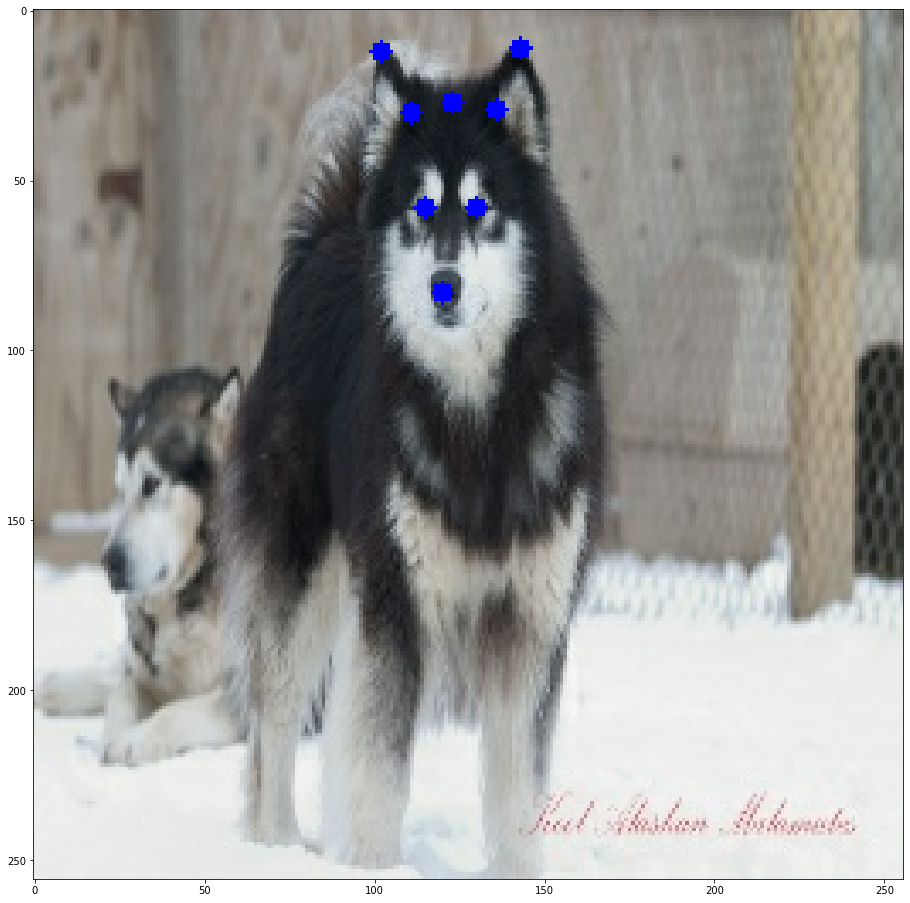

In [13]:
for i in sample_label:
  center = [int(i[0]), int(i[1])]
  cv2.circle(sample_image, center=tuple(center),radius=3, color=(0,0,255), thickness=-1, lineType=cv2.LINE_AA)

plt.figure(figsize=(16,16))
plt.imshow(sample_image)

In [3]:
import tensorflow as tf


@tf.function
def full_tfrecord_reader(example):
    feature_description = {"image": tf.io.VarLenFeature(dtype=tf.string),
                           "class": tf.io.VarLenFeature(dtype=tf.int64),
                           "bb_box": tf.io.VarLenFeature(dtype=tf.float32),
                           "landmark": tf.io.VarLenFeature(dtype=tf.float32)}

    example = tf.io.parse_single_example(example, feature_description)
    image_raw = tf.sparse.to_dense(example["image"])[0]
    image = tf.io.decode_png(image_raw, channels=3)
    image_class = tf.sparse.to_dense(example["class"])
    image_bb_box = tf.sparse.to_dense(example["bb_box"])
    image_landmark = tf.sparse.to_dense(example["landmark"])

    label = tf.concat([tf.cast(image_class, dtype=tf.float32), image_bb_box, image_landmark], axis=0)
    return image, label


@tf.function
def landmark_tfrecord_reader(example):
    feature_description = {"image": tf.io.VarLenFeature(dtype=tf.string),
                           "class": tf.io.VarLenFeature(dtype=tf.int64),
                           "bb_box": tf.io.VarLenFeature(dtype=tf.float32),
                           "landmark": tf.io.VarLenFeature(dtype=tf.float32)}

    example = tf.io.parse_single_example(example, feature_description)
    image_raw = tf.sparse.to_dense(example["image"])[0]
    image = tf.io.decode_png(image_raw, channels=3)
    image_class = tf.sparse.to_dense(example["class"])
    image_bb_box = tf.sparse.to_dense(example["bb_box"])
    image_landmark = tf.sparse.to_dense(example["landmark"])

    return image, image_landmark


@tf.function
def class_landmark_tfrecord_reader(example):
    feature_description = {"image": tf.io.VarLenFeature(dtype=tf.string),
                           "class": tf.io.VarLenFeature(dtype=tf.int64),
                           "bb_box": tf.io.VarLenFeature(dtype=tf.float32),
                           "landmark": tf.io.VarLenFeature(dtype=tf.float32)}

    example = tf.io.parse_single_example(example, feature_description)
    image_raw = tf.sparse.to_dense(example["image"])[0]
    image = tf.io.decode_png(image_raw, channels=3)
    image_class = tf.sparse.to_dense(example["class"])
    image_bb_box = tf.sparse.to_dense(example["bb_box"])
    image_landmark = tf.sparse.to_dense(example["landmark"])

    label = tf.concat([tf.cast(image_class, dtype=tf.float32), image_landmark], axis=0)

    return image, label


# train_type: label의 형태를 결정.
# data_path: tfrecord 파일이 있는 위치
# batch_size: batch size
def get_cu_dataset(train_type='landmark', data_path='./data/cu_dataset.tfrecord', batch_size=32):
    # landmark 만 label 되어있는 데이터 셋
    if train_type == 'landmark':
        ds = tf.data.TFRecordDataset(data_path).map(landmark_tfrecord_reader)
        ds = ds.map(image_resize).map(image_scaling).batch(batch_size)
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    # class와 함께 label 되어있는 데이터셋. class, landmark 순서
    elif train_type == 'class':
        ds = tf.data.TFRecordDataset(data_path).map(class_landmark_tfrecord_reader)
        ds = ds.map(image_resize).map(image_scaling).batch(batch_size)
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    # bb-box, class, landmark 모두 label. class, bb-box, landmark 순서
    else:
        ds = tf.data.TFRecordDataset(data_path).map(full_tfrecord_reader)
        ds = ds.map(image_resize).map(image_scaling).batch(batch_size)
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds


def image_resize(x, y):
    x = tf.image.resize(x, size=[256, 256])
    return x, y


def image_scaling(x, y):
    x = tf.cast(x, tf.float32) / 255.
    return x, y

In [ ]:
!pip install tfrecord_io